In [1]:
# imported Libraries
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud




c:\Users\DCL\Downloads\NLP Project\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Dataset

In [11]:
# Load the dataset
df = pd.read_csv("reviews_dataset.csv")
df.head()

,Rating,Cleaned_Comment,Label
0,4,all functions of the app work really well with...,Genuine
1,3,great app im sure its even better if you pay t...,Genuine
2,4,the app is very good for food and exercise tra...,Genuine
3,3,this overall is a pretty great app relatively ...,Genuine
4,3,ive been using the premium version of this app...,Genuine


### Data Info

In [12]:
df.info()
df.shape
df.value_counts('Label')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30379 entries, 0 to 30378
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Rating           30379 non-null  int64 
 1   Cleaned_Comment  30379 non-null  object
 2   Label            30379 non-null  object
dtypes: int64(1), object(2)
memory usage: 712.1+ KB


Label
Genuine    15856
Fake       14523
Name: count, dtype: int64

In [10]:
# Filter 'Fake' and drop 1000 rows
fake_data = df[df['Label'] == 'Fake']
genuine_data = df[df['Label'] == 'Genuine']

# Drop 1000 instances of 'Fake'
fake_data_reduced = fake_data.sample(len(fake_data) - 1000, random_state=42)

# Combine back the datasets
df_balanced = pd.concat([genuine_data, fake_data_reduced])
df_balanced.to_csv("reviews_dataset.csv", index=False)

C:\Users\DCL\AppData\Local\Temp\ipykernel_1812\3031837096.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=df, palette='viridis')


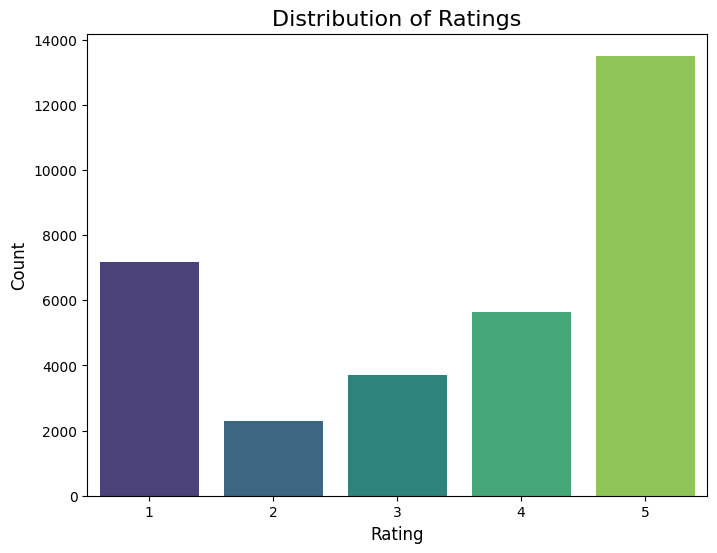

In [92]:
# Plot the distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='Rating', data=df, palette='viridis')
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


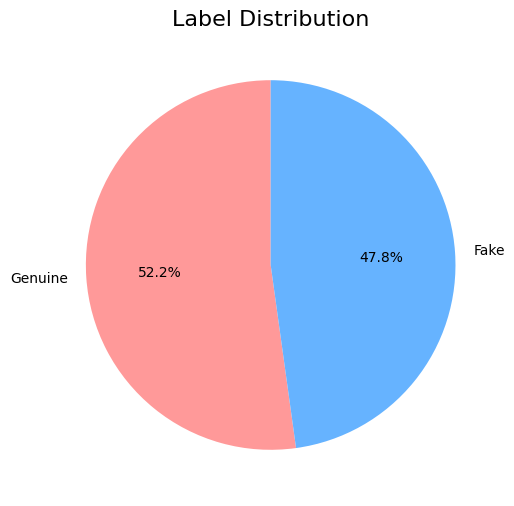

In [13]:
# Plot the label distribution
plt.figure(figsize=(8, 6))
df['Label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Label Distribution', fontsize=16)
plt.ylabel('')
plt.show()


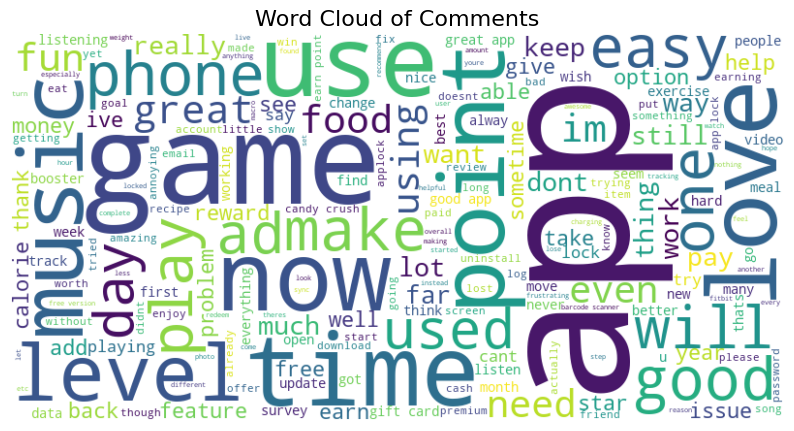

In [94]:
# Display the word cloud
text = ' '.join(str(comment) for comment in df['Comment'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments', fontsize=16)
plt.show()


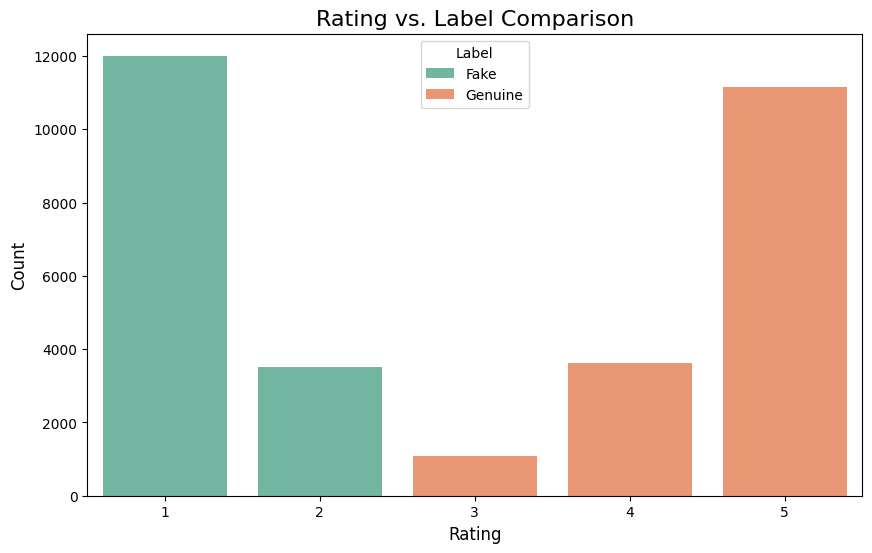

In [8]:
# Grouped bar chart for rating vs. label
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', hue='Label', data=df, palette='Set2')
plt.title('Rating vs. Label Comparison', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Label', fontsize=10)
plt.show()


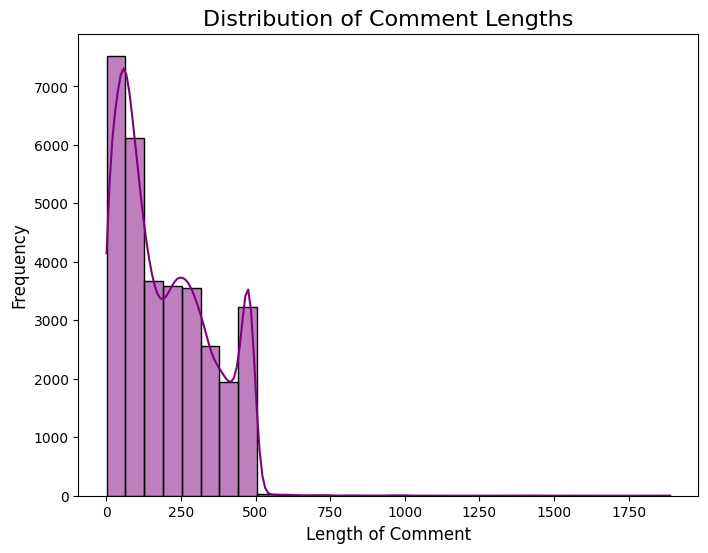

In [96]:
# Plot the distribution of comment lengths
df['Comment_Length'] = df['Comment'].dropna().apply(len)

plt.figure(figsize=(8, 6))
sns.histplot(df['Comment_Length'], bins=30, kde=True, color='purple')
plt.title('Distribution of Comment Lengths', fontsize=16)
plt.xlabel('Length of Comment', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


### Preprocess Dataset

In [13]:
# Drop rows with missing comments
df = df.dropna()

# Encode labels to numerical values
label_encoder = LabelEncoder()
df['LabelEncoded'] = label_encoder.fit_transform(df['Label'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['Comment'], 
    df['LabelEncoded'], 
    test_size=0.2, 
    random_state=42,
    stratify=df['LabelEncoded']
)


AttributeError: 'function' object has no attribute 'dropna'

### Define Dataset Class for Transformers

In [98]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]
        
        # Tokenize the text
        encoding = self.tokenizer(
            text, 
            max_length=self.max_length, 
            padding='max_length', 
            truncation=True, 
            return_tensors="pt"
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


### Load Transformer Model and Tokenizer

In [99]:
# Use pre-trained BERT model
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
transformer_model = AutoModel.from_pretrained(MODEL_NAME)


c:\Users\DCL\Downloads\NLP Project\myenv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\DCL\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


### Create Data Loaders

In [100]:
# Create Dataset objects
train_dataset = ReviewDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = ReviewDataset(X_test.tolist(), y_test.tolist(), tokenizer)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Define the Deep Learning Model

In [101]:
class SentimentClassifier(nn.Module):
    def __init__(self, transformer_model, num_classes):
        super(SentimentClassifier, self).__init__()
        self.transformer = transformer_model
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.transformer.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        transformer_outputs = self.transformer(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        pooled_output = transformer_outputs[1]  # Use pooled output
        dropout_output = self.dropout(pooled_output)
        output = self.fc(dropout_output)
        return output

# Initialize model
num_classes = len(label_encoder.classes_)
model = SentimentClassifier(transformer_model, num_classes)


###  Define Training Loop

In [102]:
def train_model(model, train_loader, test_loader, epochs=3, learning_rate=2e-5):
    # Define optimizer, loss, and device
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

    print("Training complete.")


### Train the Model

In [ ]:
train_model(model, train_loader, test_loader, epochs=5)


  0%|          | 3/807 [05:36<25:02:19, 112.11s/it]


KeyboardInterrupt: 

### Save the Model

In [ ]:
#torch.save(model.state_dict(), "sentiment_classifier.pt")
